# Training Convergence Plots for Learning Punctuation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

from conv_plots_funcs import train_conv_plots

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from check_ecdf import get_empirical_cdf

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


In [2]:
valA = "ident"
valC = "_ident_C"
state_dim = 5
ckpt_step = 8
batch_size=4096
gpus=1
num_val_sys = 25
experiment = "250125_110549.80eba5_multi_sys_trace_ident_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False


compute_more_ckpts = True

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_ident_state_dim_5_val_sys_25_1737948963.4647467.pdf
ckpt_steps: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 735

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

(array([0.48531914, 0.79314184, 1.2108328 ], dtype=float32),
 [204800,
  409600,
  614400,
  819200,
  1024000,
  1228800,
  1433600,
  1638400,
  1843200,
  2048000,
  2252800,
  2457600,
  2662400,
  2867200,
  3072000,
  3276800,
  3481600,
  3686400,
  3891200,
  4096000,
  4300800,
  4505600,
  4710400,
  4915200,
  5120000,
  5324800,
  5529600,
  5734400,
  5939200,
  6144000,
  6348800,
  6553600,
  6758400,
  6963200,
  7168000,
  7372800,
  7577600,
  7782400,
  7987200,
  8192000,
  8396800,
  8601600,
  8806400,
  9011200,
  9216000,
  9420800,
  9625600,
  9830400,
  10035200,
  10240000,
  10444800,
  10649600,
  10854400,
  11059200,
  11264000,
  11468800,
  11673600,
  11878400,
  12083200,
  12288000,
  12492800,
  12697600,
  12902400,
  13107200,
  13312000,
  13516800,
  13721600,
  13926400,
  14131200,
  14336000,
  14540800,
  14745600,
  14950400,
  15155200,
  15360000,
  15564800,
  15769600,
  15974400,
  16179200,
  16384000,
  16588800,
  16793600,
  16998

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

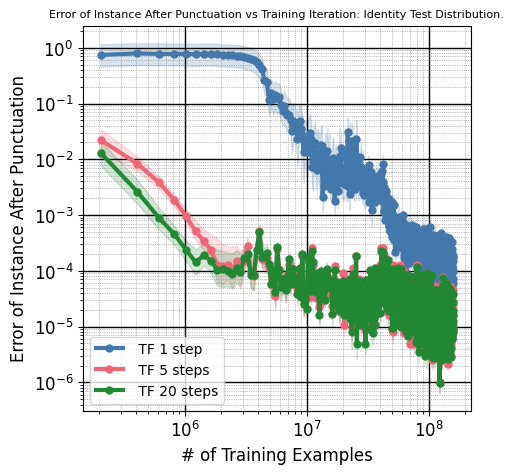

In [4]:
kal_ckpt = 81000 #28500
train_conv_plots([experiment], ["Identity"], [kal_ckpt], valA, valC, num_val_sys, compute_more_ckpts, None, 50, 300000, 50, state_dim, single_system=True, nope=nope, batch_size=batch_size, gpus=gpus)